In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import itertools
from PIL import Image, ImageChops, ImageEnhance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [13]:
image_size = (128, 128)
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [14]:
X = [] # ELA converted images
Y = [] # 0 for forged, 1 for authentic

In [15]:
path = 'dataset/authentic'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)

In [16]:
path = 'dataset/forged'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)

In [17]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [19]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

base_model_resnet = ResNet50(input_shape=(128, 128, 3),
                             include_top=False, weights='imagenet')

for layer in base_model_resnet.layers:
    layer.trainable = False

x_resnet = layers.Flatten()(base_model_resnet.output)
x_resnet = layers.Dense(1024, activation='relu')(x_resnet)
x_resnet = layers.Dropout(0.2)(x_resnet)
x_resnet = layers.Dense(2, activation='softmax')(x_resnet)

model_resnet = tf.keras.models.Model(base_model_resnet.input, x_resnet)

model_resnet.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

mc_resnet = tf.keras.callbacks.ModelCheckpoint(filepath="./resnet_best_model.keras",
                                               monitor='val_accuracy',
                                               verbose=1,
                                               save_best_only=True,
                                               mode='auto')

resnet_callbacks = [mc_resnet]

resnet_history = model_resnet.fit(X_train, Y_train,
                                  epochs=50,
                                  validation_data=(X_val, Y_val),
                                  callbacks=resnet_callbacks)

model_resnet.save('model_resnet.keras')

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.4887 - loss: 1.0508
Epoch 1: val_accuracy improved from -inf to 0.52750, saving model to ./resnet_best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 375ms/step - accuracy: 0.4888 - loss: 1.0480 - val_accuracy: 0.5275 - val_loss: 0.7380
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.4963 - loss: 0.8116
Epoch 2: val_accuracy did not improve from 0.52750
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 344ms/step - accuracy: 0.4963 - loss: 0.8114 - val_accuracy: 0.5275 - val_loss: 0.8813
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.4975 - loss: 0.8088
Epoch 3: val_accuracy did not improve from 0.52750
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 341ms/step - accuracy: 0.4973 - loss: 0.8088 - val_accuracy: 0.5275 - val_loss: 0.8313
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5076 - loss: 0.7792
Epoch 4: val_accuracy did not improve from 0.52750
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 

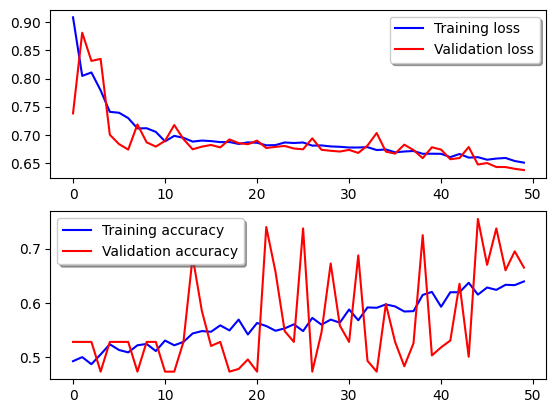

In [22]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(resnet_history.history['loss'], color='b', label="Training loss")
ax[0].plot(resnet_history.history['val_loss'], color='r', label="Validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(resnet_history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(resnet_history.history['val_accuracy'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step


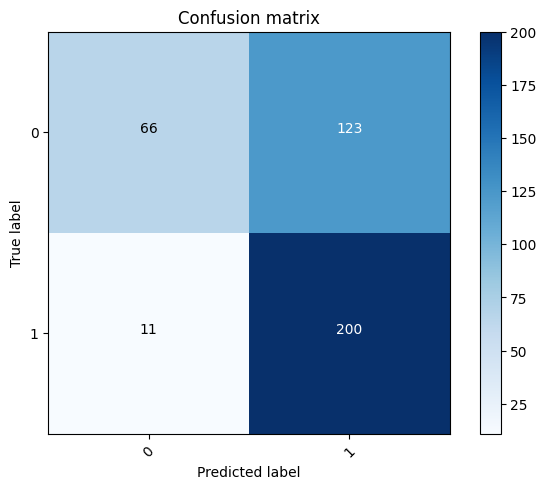

In [23]:
Y_pred_resnet = model_resnet.predict(X_val)
Y_pred_classes_resnet = np.argmax(Y_pred_resnet, axis=1)
Y_true_resnet = np.argmax(Y_val, axis=1)
confusion_mtx_resnet = confusion_matrix(Y_true_resnet, Y_pred_classes_resnet)
plot_confusion_matrix(confusion_mtx_resnet, classes=range(2))

In [24]:
print("Classification report for ResNet50:")
print(classification_report(Y_true_resnet, Y_pred_classes_resnet, target_names=['forged', 'authentic']))
accuracy_resnet = accuracy_score(Y_true_resnet, Y_pred_classes_resnet)
print("Overall accuracy for ResNet50: {:.2f}%".format(accuracy_resnet*100))

Classification report for ResNet50:
              precision    recall  f1-score   support

      forged       0.86      0.35      0.50       189
   authentic       0.62      0.95      0.75       211

    accuracy                           0.67       400
   macro avg       0.74      0.65      0.62       400
weighted avg       0.73      0.67      0.63       400

Overall accuracy for ResNet50: 66.50%


In [25]:
sample_paths = [
    'dataset/authentic/33.jpg',
    'dataset/authentic/34.jpg',
    'dataset/authentic/35.jpg',
    'dataset/authentic/335.jpg',
    'dataset/authentic/336.jpg',
    'dataset/authentic/337.jpg',
    'dataset/authentic/338.jpg',
    'dataset/authentic/339.jpg',
    'dataset/forged/1257_1258.png',
    'dataset/forged/1259_1260.png',
    'dataset/forged/1261_1262.png',
    'dataset/forged/1262_1263.png',
    'dataset/forged/1265_1266.png',
    'dataset/forged/1266_1267.png',
    'dataset/forged/1269_1270.png',
    'dataset/forged/1271_1272.png',
    'dataset/forged/1273_1274.png',
    'dataset/forged/1276_1277.png',
]

In [26]:
for sample_path in sample_paths:
    image = prepare_image(sample_path)
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model_resnet.predict(image)
    y_pred_class = np.argmax(y_pred, axis = 1)[0]
    class_names = ['forged', 'authentic']
    print(f'Image: {sample_path}, Predicted class: {class_names[y_pred_class]}, Confidence: {np.amax(y_pred) * 100:0.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: dataset/authentic/33.jpg, Predicted class: authentic, Confidence: 55.88%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image: dataset/authentic/34.jpg, Predicted class: authentic, Confidence: 50.95%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image: dataset/authentic/35.jpg, Predicted class: authentic, Confidence: 50.88%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image: dataset/authentic/335.jpg, Predicted class: authentic, Confidence: 66.42%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: dataset/authentic/336.jpg, Predicted class: authentic, Confidence: 57.65%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image: dataset/authentic/337.jpg, Predicted class: authentic, Confidence: 56.92%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image: dataset/authentic/338.jpg, Predicted class: forged, Confidence: 50.38%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: dataset/authentic/339.jpg, Predicted class: authentic, Confidence: 64.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: dataset/f

In [27]:
correct = 0
total = 0

for dirname, _, filenames in os.walk('dataset/forged'):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            image_path = os.path.join(dirname, filename)
            image = prepare_image(image_path)
            image = image.reshape(-1, 128, 128, 3)
            y_pred = model_resnet.predict(image)
            y_pred_class = np.argmax(y_pred, axis = 1)[0]
            total += 1
            if y_pred_class == 0:
                correct += 1

for dirname, _, filenames in os.walk('dataset/authentic'):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            image_path = os.path.join(dirname, filename)
            image = prepare_image(image_path)
            image = image.reshape(-1, 128, 128, 3)
            y_pred = model_resnet.predict(image)
            y_pred_class = np.argmax(y_pred, axis = 1)[0]
            total += 1
            if y_pred_class == 1:
                correct += 1

print(f'Total: {total}, Correct: {correct}, Accuracy: {correct / total * 100.0:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


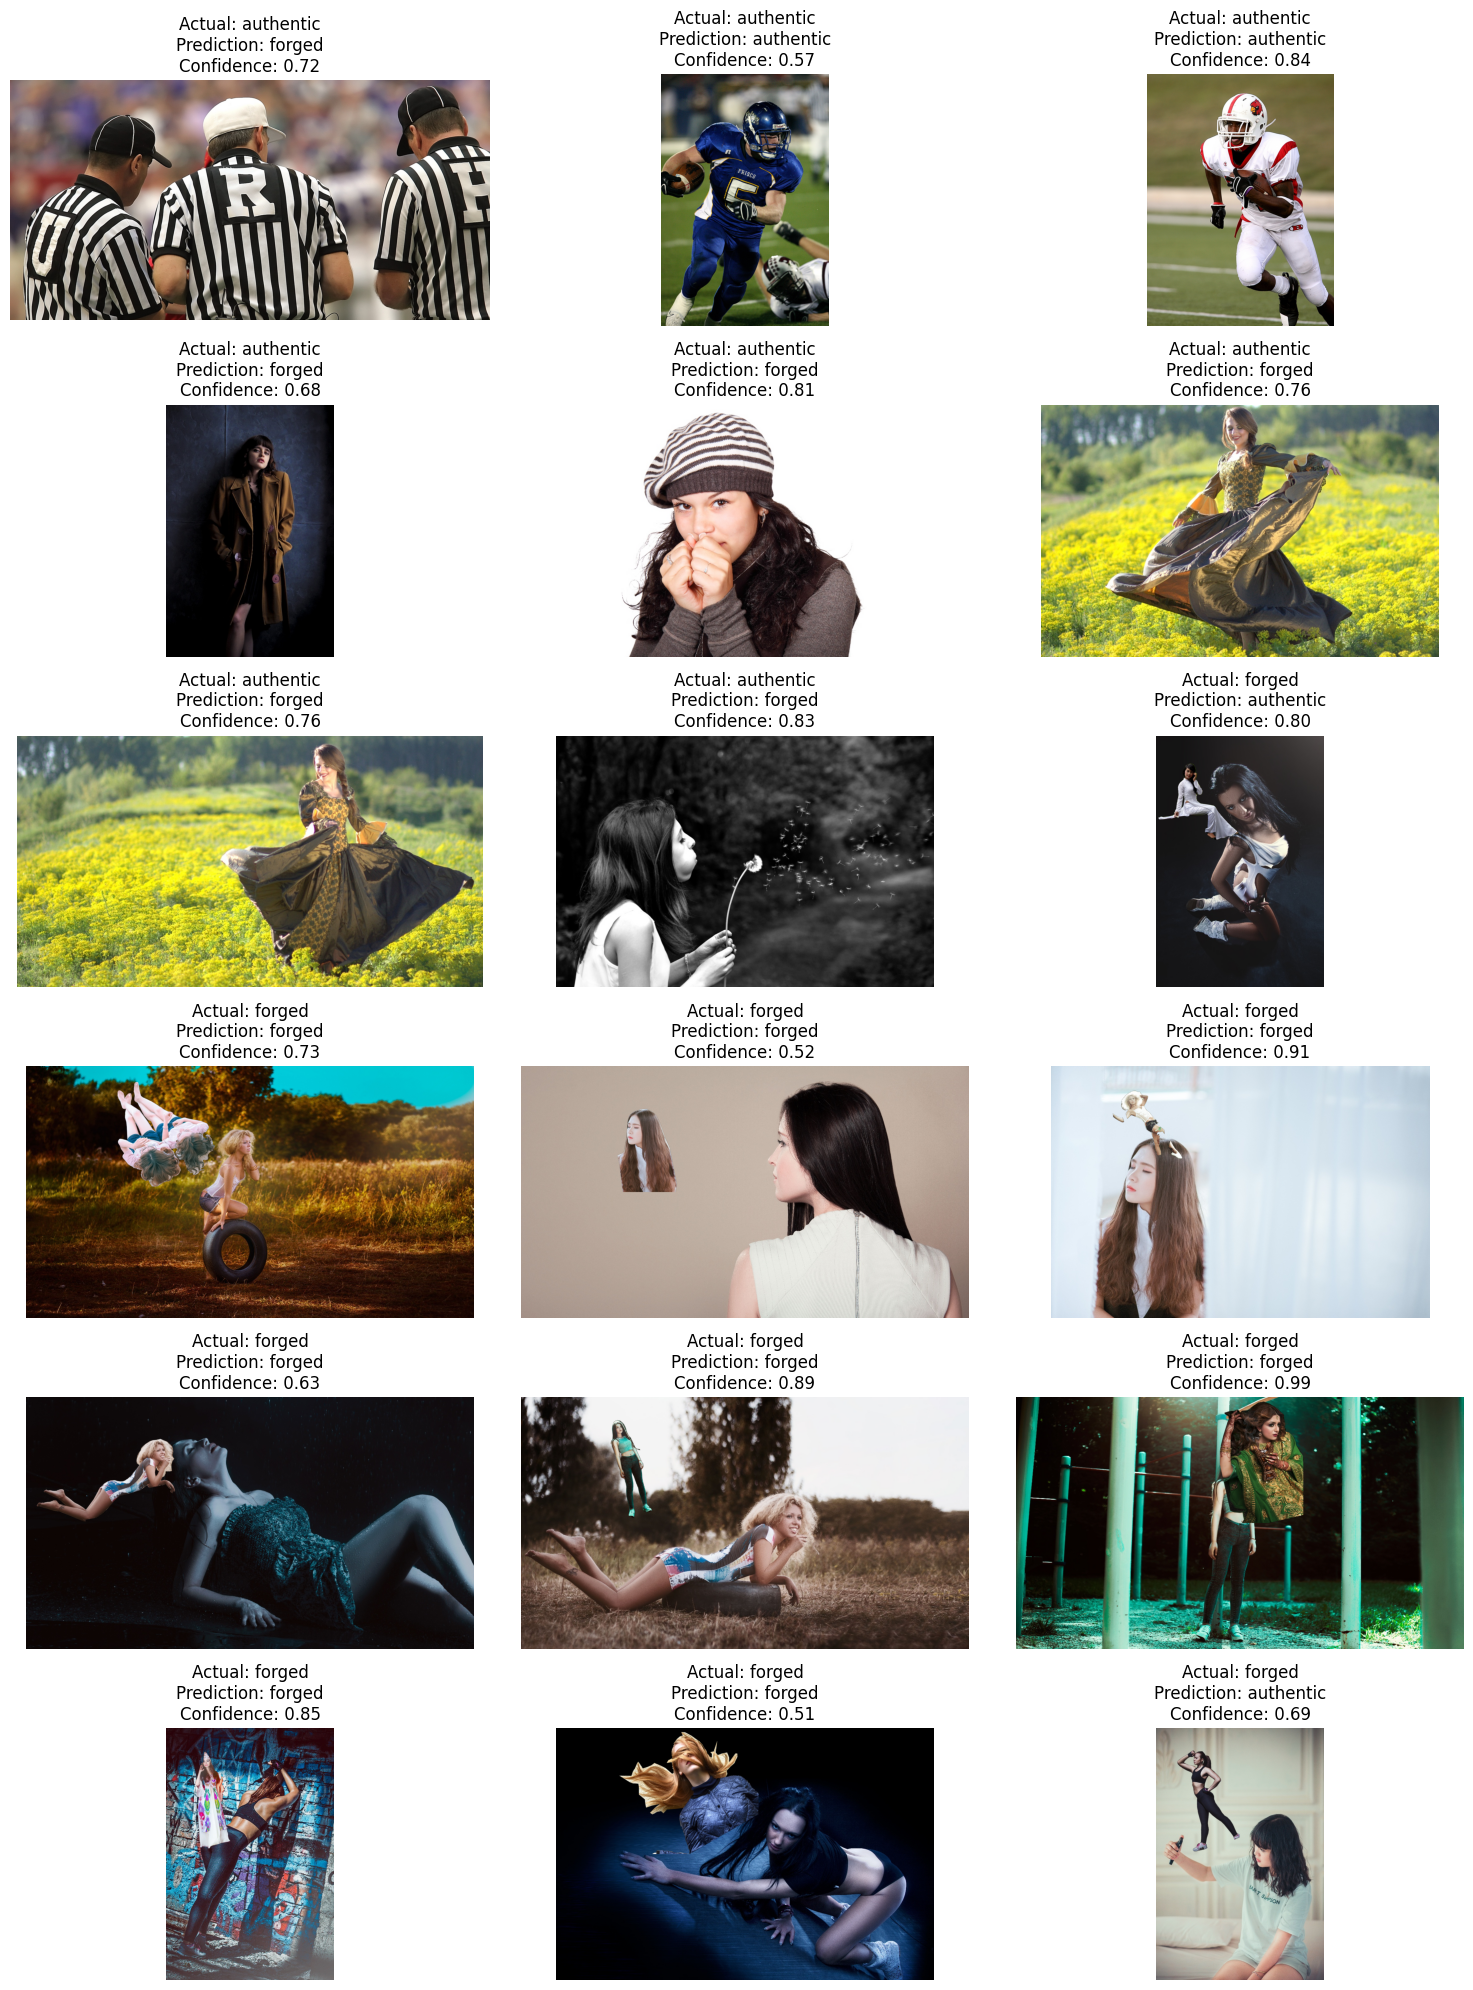

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def prepare_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(image_size)  # Resize to (128, 128)
    img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    return img

class_labels = ['authentic', 'forged']

num_images = len(sample_paths)
num_cols = 3  # Number of columns in the grid
num_rows = -(-num_images // num_cols)
plt.figure(figsize=(15, 20))

for i, image_path in enumerate(sample_paths):
    preprocessed_img = prepare_image(image_path)
    
    preprocessed_img = np.expand_dims(preprocessed_img, axis=0)  # Add batch dimension

    try:
        pred_probs = model_resnet.predict(preprocessed_img)[0]
    except Exception as e:
        print(f"Error predicting {image_path}: {e}")
        continue
    
    predicted_class = np.argmax(pred_probs)
    predicted_label = class_labels[predicted_class]
    confidence = pred_probs[predicted_class]
    
    if 'authentic' in image_path.lower():
        actual_label = 'authentic'
    elif 'forged' in image_path.lower():
        actual_label = 'forged'
    else:
        actual_label = 'Unknown'  # Default if the label is not clear from the filename

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(Image.open(image_path))
    plt.title(f"Actual: {actual_label}\nPrediction: {predicted_label}\nConfidence: {confidence:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()